# Question 3

In [9]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/b23shen/CS2529_Project.git
# !mv CS2529_Project/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

In [10]:
import torch
from torch.fft import fft2, ifft2
import numpy as np
from utils.create_noisy_images_utils import BSDS300Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Lambda
from utils.models import Unet
import statistics
import skimage.io 

from skimage.filters import gaussian
from scipy.ndimage import median_filter

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class BlurredBSDS300Dataset(BSDS300Dataset):
    def __init__(self, root='./data/BSDS300', patch_size=32, split='train', use_patches=True,
                 kernel_size=7, sigma=2, return_kernel=True):
        super(BlurredBSDS300Dataset, self).__init__(root, patch_size, split)

        # trim images to even size
        self.images = self.images[..., :-1, :-1]
        self.kernel_size = kernel_size
        self.return_kernel = return_kernel

        # extract blur kernel (use an MNIST digit)
        self.kernel_dataset = MNIST('./', train=True, download=True,
                                    transform=Compose([Lambda(lambda x: np.array(x)),
                                                       ToTensor(),
                                                       Lambda(lambda x: x / torch.sum(x))]))

        kernels = torch.cat([x[0] for (x, _) in zip(self.kernel_dataset, np.arange(self.images.shape[0]))])
        kernels = torch.nn.functional.interpolate(kernels[:, None, ...], size=2*(kernel_size,))
        kernels = kernels / torch.sum(kernels, dim=(-1, -2), keepdim=True)
        self.kernel = kernels[[0]].repeat(kernels.shape[0], 1, 1, 1)

        # blur the images
        H = psf2otf(self.kernel, self.images.shape)
        self.blurred_images = ifft2(fft2(self.images) * H).real
        self.blurred_patches = self.patchify(self.blurred_images, patch_size)

        # save which blur kernel is used for each image
        self.patch_kernel = self.kernel.repeat(1, len(self.blurred_patches) // len(self.images), 1, 1)
        self.patch_kernel = self.patch_kernel.view(-1, *self.kernel.shape[-2:])

        # reshape kernel
        self.kernel = self.kernel.squeeze()

    def get_kernel(self, kernel_size, sigma):
        kernel = self.gaussian(kernel_size, sigma)
        kernel_2d = torch.matmul(kernel.unsqueeze(-1), kernel.unsqueeze(-1).t())
        return kernel_2d

    def __getitem__(self, idx):
        out = [self.blurred_images[idx][None, ...].to(device),
               self.images[idx][None, ...].to(device)]
        if self.return_kernel:
            out.append(self.kernel[[idx]].to(device))

        return out

In [13]:
def img_to_numpy(x):
    return np.clip(x.detach().cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1)


def psf2otf(psf, shape):
    inshape = psf.shape
    psf = torch.nn.functional.pad(psf, (0, shape[-1] - inshape[-1], 0, shape[-2] - inshape[-2], 0, 0))

    # Circularly shift OTF so that the 'center' of the PSF is [0,0] element of the array
    psf = torch.roll(psf, shifts=(-int(inshape[-1] / 2), -int(inshape[-2] / 2)), dims=(-1, -2))

    # Compute the OTF
    otf = fft2(psf)

    return otf


def calc_psnr(x, gt):
    out = 10 * np.log10(1 / ((x - gt)**2).mean().item())
    return out


def wiener_deconv(x, kernel):
    snr = 100  # use this SNR parameter for your results
    H = psf2otf(kernel, x.shape).to(device)
    G = torch.conj(H) * 1/(1/snr + H*torch.conj(H)).to(device)
    return ifft2(fft2(x) * G).real


def load_models():
    model_deblur_denoise = Unet().to(device)
    model_deblur_denoise.load_state_dict(torch.load('utils/models/pretrained/deblur_denoise.pth', map_location=device))

    model_denoise = Unet().to(device)
    model_denoise.load_state_dict(torch.load('utils/models/pretrained/denoise.pth', map_location=device))

    return model_deblur_denoise, model_denoise

In [14]:
def fspecial_gaussian_2d(size, sigma):
    kernel = np.zeros(tuple(size))
    kernel[size[0]//2, size[1]//2] = 1
    kernel = gaussian(kernel, sigma)
    return kernel/np.sum(kernel)

def bilateral2d(img, radius, sigma, sigmaIntensity):
    pad = radius
    # Initialize filtered image to 0
    out = np.zeros_like(img)

    # Pad image to reduce boundary artifacts
    imgPad = np.pad(img, pad)

    # Smoothing kernel, gaussian with standard deviation sigma
    # and size (2*radius+1, 2*radius+1)
    filtSize = (2*radius + 1, 2*radius + 1)
    spatialKernel = fspecial_gaussian_2d(filtSize, sigma)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            I = imgPad[x+pad][y+pad]

            # create a window
            window = np.zeros((2*radius + 1, 2*radius + 1))
            for i in range(-radius, radius+1):
                for j in range(-radius, radius+1):
                    if (0 <= x+i+pad < img.shape[0] and 0 <= y+j+pad < img.shape[1]):
                        window[radius+i][radius+j] = imgPad[x+i+pad][y+j+pad]

            intensity = np.exp((-np.square(window-I))/(2*sigmaIntensity**2))

            Wp = np.sum(intensity*spatialKernel)
            # Go over a window of size (2*radius + 1) around the current pixel,
            # compute weights, sum the weighted intensity.
            # Don't forget to normalize by the sum of the weights used.

            out[x][y] = np.sum(window*intensity*spatialKernel)/Wp
    return out

def inbounds(img, y, x):
    return 0 <= y and y < img.shape[0] and \
           0 <= x and x < img.shape[1]

def comparePatches(patch1, patch2, kernel, sigma):
    return np.exp(-np.sum(kernel*(patch1 - patch2) ** 2)/(2*sigma**2))

def nonlocalmeans(img, searchWindowRadius, averageFilterRadius, sigma, nlmSigma):
    # Initialize output to 0
    out = np.zeros_like(img)
    # Pad image to reduce boundary artifacts
    pad = max(averageFilterRadius, searchWindowRadius)
    imgPad = np.pad(img, pad)
    imgPad = imgPad[..., pad:-pad] # Don't pad third channel

    # Smoothing kernel
    filtSize = (2*averageFilterRadius + 1, 2*averageFilterRadius + 1)
    kernel = fspecial_gaussian_2d(filtSize, sigma)
    # Add third axis for broadcasting
    kernel = kernel[:, :, np.newaxis]
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            # patch for the pixel i
            pixel_i = imgPad[y+pad][x+pad]
            centerPatch = imgPad[y+pad-averageFilterRadius:y+pad+averageFilterRadius+1,
                                 x+pad-averageFilterRadius:x+pad+averageFilterRadius+1,
                                 :]
            Z = np.zeros((2*searchWindowRadius+1, 2*searchWindowRadius+1, 1))
            # Go over a window around the current pixel, compute weights
            # based on difference of patches, sum the weighted intensity
            # Hint: Do NOT include the patches centered at the current pixel
            # in this loop, it will throw off the weights
            weights = np.zeros((2*searchWindowRadius+1, 2*searchWindowRadius+1, 1))

            # This makes it a bit better: Add current pixel as well with max weight
            # computed from all other neighborhoods.
            max_weight = 0

            # creates a window of size: searchWindowRadius
            window = imgPad[y+pad-searchWindowRadius:y+pad+searchWindowRadius+1, 
                            x+pad-searchWindowRadius:x+pad+searchWindowRadius+1,
                            :]

            # go through OTHER pixels (pixel j) in the window
            for b in range(-searchWindowRadius, searchWindowRadius+1):
                for a in range(-searchWindowRadius, searchWindowRadius+1):
                    if (b != 0 and a != 0):
                        pixel_j = imgPad[y+b+pad][x+a+pad]
                        # create a patch for pixel j, if some pixels (say pixel(m,n)) in the patch are outside
                        # the window, then set them to 0

                        # check boundary
                        if inbounds(imgPad, y+b+pad-averageFilterRadius, 
                            x+a+pad-averageFilterRadius) and inbounds(imgPad, y+b+pad+averageFilterRadius, 
                            x+a+pad+averageFilterRadius):
                            patch_j = imgPad[y+b+pad-averageFilterRadius:y+b+pad+averageFilterRadius+1, 
                                             x+a+pad-averageFilterRadius:x+a+pad+averageFilterRadius+1,
                                             :]
                        else:
                            patch_j = np.zeros_like(centerPatch)
                            for m in range(-averageFilterRadius,averageFilterRadius+1):
                                for n in range(-averageFilterRadius,averageFilterRadius+1):
                                    pixel_in_patch_y = y+b+pad+m
                                    pixel_in_patch_x = x+a+pad+n
                                    if inbounds(imgPad, pixel_in_patch_y, pixel_in_patch_x):
                                        patch_j[m+averageFilterRadius][n+averageFilterRadius] = imgPad[y+b+pad+m][x+a+pad+n]



                        weights[b+searchWindowRadius][a+searchWindowRadius] = comparePatches(centerPatch, patch_j, kernel, nlmSigma)
                        Z[b+searchWindowRadius][a+searchWindowRadius] = comparePatches(centerPatch, patch_j, kernel, nlmSigma)*pixel_j
            out[y, x, :] = np.sum(Z)/np.sum(weights)
    return out


In [21]:
def evaluate_model():

    # create the dataset
    dataset = BlurredBSDS300Dataset(split='test')

    # load the models
    model_deblur_denoise, model_denoise = load_models()

    # put into evaluation mode
    model_deblur_denoise.eval()
    model_denoise.eval()
    
    PSNRs = []

#     for sigma in [0.01, 0.02, 0.05]:
    for sigma in [0.01, 0.02, 0.05]:

        filtSize = 2*sigma + 1
        
        psnr_m1 = []
        psnr_m2 = []
        psnr_m3 = []
        psnr_m4 = []
        psnr_m5 = []
        psnr_m6 = []
        psnr_m7 = []
        
        index = 0

        for image, gt, kernel in dataset:

            ################################################################################
            # TODO: Your code goes here!
            ################################################################################

            # add noise to the image
            
            image = image + sigma * torch.tensor(np.random.randn(*image.shape)).to(device)
            
            skimage.io.imshow((img_to_numpy(gt)*255).astype(np.uint8))

            # apply each method (wiener deconvolution and the two networks)
            
            # Method 1: Wiener deconvolution
            
            image_deconv = wiener_deconv(image, kernel)
            
            psnr_m1.append(calc_psnr(image_deconv, gt))
            
            # Method 2: Neural Network for deconvolution + denoising
            
            image_neural = model_deblur_denoise(image.to(dtype=torch.float))
            
            psnr_m2.append(calc_psnr(image_neural, gt))
            
            # Method 3: Wiener deconvolution + Neural Network denoising
            
            image_deconv_neural = model_denoise(image_deconv.to(dtype=torch.float))
            
            psnr_m3.append(calc_psnr(image_deconv_neural, gt))

            # Method 4: Gaussian Filter
            
            np_img = img_to_numpy(image)
            image_Gaussian_filter = np.zeros_like(np_img)
            for channel in [0, 1, 2]:
                image_Gaussian_filter[:,:, channel] = gaussian(np_img[:,:, channel], sigma = 1)
            psnr_m4.append(calc_psnr(image_Gaussian_filter, img_to_numpy(gt)))

            # Method 5: Median Filter
            
            np_img = img_to_numpy(image)
            image_Median_filter = np.zeros_like(np_img)
            for channel in [0, 1, 2]:
                image_Median_filter[:,:, channel] = median_filter(np_img[:,:, channel], size=3)
            psnr_m5.append(calc_psnr(image_Median_filter, img_to_numpy(gt)))

            # Method 6: Bilateral
            sigmaIntensity = 0.25
            bilateral = np.zeros_like(np_img)
            for channel in [0, 1, 2]:
                bilateral[:,:, channel] = bilateral2d(np_img[:,:, channel],
                                              radius=1,
                                              sigma=1,
                                              sigmaIntensity=sigmaIntensity)
            psnr_m6.append(calc_psnr(bilateral, img_to_numpy(gt)))
            
            # Method 7: Non Local Mean
            nlmSigma = 0.1  # Feel free to modify
            searchWindowRadius = 5
            averageFilterRadius = 1
            nlm = np.zeros_like(np_img)
            # for channel in [0,1,2]:
              # nlm[...,channel:channel+1] = nonlocalmeans(np_img[..., channel:channel+1],searchWindowRadius,averageFilterRadius,1,nlmSigma)
            psnr_m7.append(calc_psnr(nlm, img_to_numpy(gt)))

            filename = 'data/noisyss/'
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_gt.png', (img_to_numpy(gt)*255).astype(np.uint8))
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_noisy.png', (img_to_numpy(image)*255).astype(np.uint8))
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_deconv.png', (img_to_numpy(image_deconv)*255).astype(np.uint8))
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_neural.png', (img_to_numpy(image_neural)*255).astype(np.uint8))
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_deconv_neural.png', (img_to_numpy(image_deconv_neural)*255).astype(np.uint8))
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_Gaussian_filt.png', (image_Gaussian_filter*255).astype(np.uint8))
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_Median_filt.png', (image_Median_filter*255).astype(np.uint8))
            skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_bilateral.png', (bilateral*255).astype(np.uint8))
            # skimage.io.imsave(filename + str(index) + '_sigma=' + str(sigma) + '_nlm.png', (nlm*255).astype(np.uint8))
            
            index = index + 1
    
        PSNRs.append(statistics.mean(psnr_m1))
        PSNRs.append(statistics.mean(psnr_m2))
        PSNRs.append(statistics.mean(psnr_m3))
        PSNRs.append(statistics.mean(psnr_m4))
        PSNRs.append(statistics.mean(psnr_m5))
        PSNRs.append(statistics.mean(psnr_m6))
        PSNRs.append(statistics.mean(psnr_m7))
  
    print(PSNRs)

            # save the psnrs

            # save out sample images to include in your writeup

            # HINT: use the calc_psnr function to calculate the PSNR, and use the
            # wiener_deconv function to perform wiener deconvolution

[28.876041399630175, 35.13743129444029, 36.0309783026169, 29.76113144882562, 29.943034601646254, 29.420508128702618, 6.540757468318718, 23.072651393788014, 27.49218147060607, 29.82860896545904, 29.638276412135006, 29.669262227035272, 29.24518643514863, 6.540757468318718, 15.192643219093513, 19.069711008610724, 21.137092566980094, 28.894480912076443, 28.252685531224735, 28.14686991542363, 6.540757468318718]


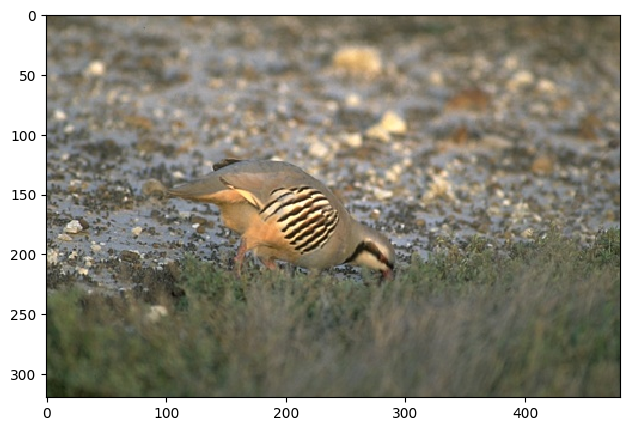

In [22]:
if __name__ == '__main__':
    evaluate_model()